# Get Started With Image Generation

References:

https://www.tensorflow.org/tutorials/generative/cvae

https://keras.io/examples/generative/vae/




## Create the Environment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load data

In [3]:
fashion_data = keras.datasets.fashion_mnist.load_data()
(x_train,y_train),(x_val,y_val)= fashion_data 

x_train.shape, x_val.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [4]:
del y_train, y_val

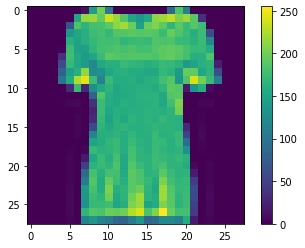

In [5]:
plt.imshow(x_train[10])
plt.colorbar()
plt.show() 

In [6]:
data = tf.concat([x_train, x_val], axis=0)
data = tf.expand_dims(data, -1)
data = tf.cast(data, tf.float32)
data = data / 255.0

## Build the Sampler

In [7]:
class Sampling(layers.Layer):
    
    def call(self, inputs):
        mean, logvar = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        eps = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * logvar) * eps
    

## Build the Encoder network

In [8]:
# latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mean = layers.Dense(2, name="mean")(x)
logvar = layers.Dense(2, name="logvar")(x)
z = Sampling()([mean, logvar])
encoder = keras.Model(encoder_inputs, [mean, logvar, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

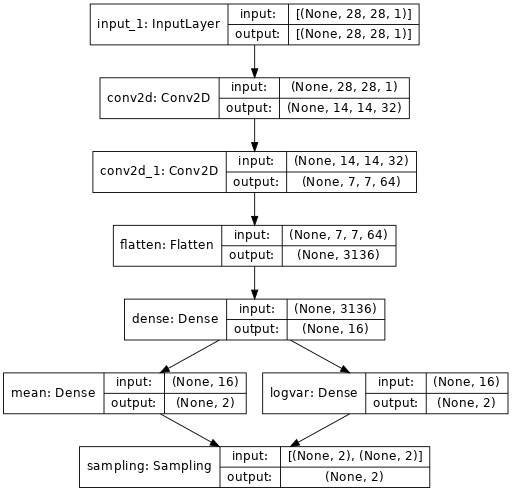

In [9]:
keras.utils.plot_model(encoder, show_shapes=True, dpi=64)

## Build the Decoder network

In [10]:
latent_inputs = keras.Input(shape=(2,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# form 7 by 7 feature map
x = layers.Reshape((7, 7, 64))(x)
# form 14 by 14 feature map
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# form 28 by 28 feature map
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# form the sigmoid output
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

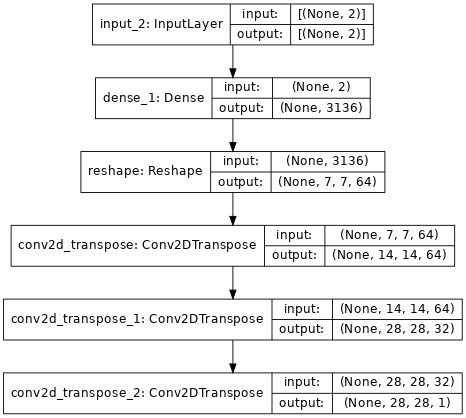

In [11]:
keras.utils.plot_model(decoder, show_shapes=True, dpi=64)

### Define Training with metrics and losses

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, logvar, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train the model

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(data, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 50s 90ms/step - loss: 380.9545 - reconstruction_loss: 321.5853 - kl_loss: 5.3950
Epoch 2/30
547/547 [==============================] - 46s 85ms/step - loss: 275.6313 - reconstruction_loss: 268.4843 - kl_loss: 5.7082
Epoch 3/30
547/547 [==============================] - 47s 85ms/step - loss: 270.7865 - reconstruction_loss: 264.7329 - kl_loss: 5.8327
Epoch 4/30
547/547 [==============================] - 47s 85ms/step - loss: 269.1564 - reconstruction_loss: 262.9281 - kl_loss: 5.8931
Epoch 5/30
547/547 [==============================] - 47s 85ms/step - loss: 268.0636 - reconstruction_loss: 261.5922 - kl_loss: 5.9404
Epoch 6/30
547/547 [==============================] - 47s 85ms/step - loss: 267.4780 - reconstruction_loss: 260.7771 - kl_loss: 5.9749
Epoch 7/30
547/547 [==============================] - 47s 85ms/step - loss: 265.9326 - reconstruction_loss: 259.9921 - kl_loss: 6.0175
Epoch 8/30
547/547 [==============================] - 4

## Plot the Performance

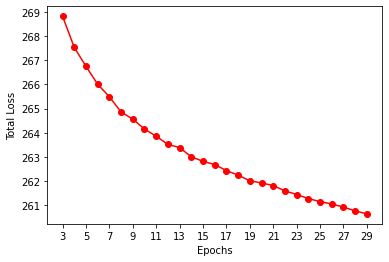

In [32]:
loss = history.history['loss']
# plot loss from 4rd epoch onwards
index = np.arange(3, 30)
plt.plot(index, loss[3:], 'o-r')
plt.xticks(np.arange(3, 30, 2))
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.show()

## Sample Mean & Variance, and Generate some images 

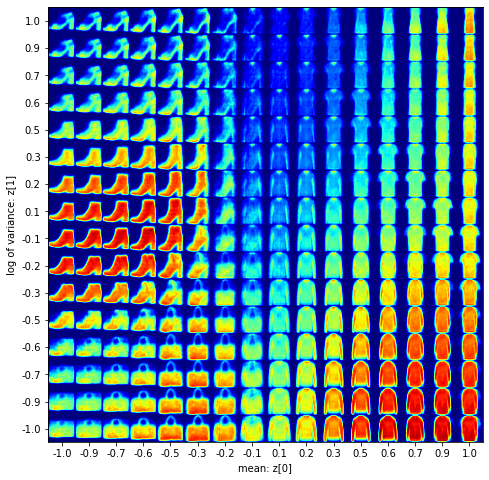

In [18]:
def plot_latent_space(vae, n=16, figsize=8):
    # display a n*n 2D manifold of fashion data
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean: z[0]")
    plt.ylabel("log of variance: z[1]")
    plt.imshow(figure, cmap="jet")
    plt.show()


plot_latent_space(vae)

### Thank you for your time!